# Developing `make_ww3_wind_file` Worker

Code experiments and verification for the `make_ww3_wind_file` worker.

wwatch3 requires the wind forcing file that is input to `ww3_prnc`
to have a structure similar this ocean currents file:

```
netcdf GSL5km_2009_CUR {
dimensions:
    longitude = 150 ;
    latitude = 236 ;
    time = UNLIMITED ; // (8760 currently)
variables:
    double time(time) ;
        time:long_name = "Time" ;
        time:time_origin = "2009-01-01 01:00:00" ;
        time:delta_t = "0000-00-00 01:00:00" ;
        time:units = "days since 2009-01-01T01:00:00Z" ;
    double latitude(latitude, longitude) ;
        latitude:long_name = "Latitude" ;
        latitude:units = "degrees_north" ;
    double longitude(latitude, longitude) ;
        longitude:long_name = "Longitude" ;
        longitude:units = "degrees_east" ;
    double uas(time, latitude, longitude) ;
        uas:standard_name = "uas" ;
        uas:long_name = "East component of current" ;
        uas:units = "m s-1" ;
    double vas(time, latitude, longitude) ;
        vas:standard_name = "vas" ;
        vas:long_name = "North component of current" ;
        vas:units = "m s-1" ;

```
(Example courtesy of Caroline Sevigny at Université du Québec à Rimouski)

The worker needs to transform the `time_counter`,
`nav_lon`,
`nav_lat`,
`u_wind`,
and `v_wind` variable from files like

`/results/forcing/atmospheric/GEM2.5/operational/ops_y2017m03d17.nc`

to produce an netCDF4 file with a structure similar to above that `ww3_prnc` will accept.

It turns out that `xarray` makes it quite easy to produce such a file.

In [1]:
import arrow
import cmocean
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import xarray as xr

In [2]:
%matplotlib inline

In [4]:
hrdps = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m04d06.nc')
hrdps

<xarray.Dataset>
Dimensions:       (time_counter: 24, x: 256, y: 266)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-04-06 ...
  * x             (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * y             (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
Data variables:
    atmpres       (time_counter, y, x) float64 1.011e+05 1.011e+05 1.011e+05 ...
    nav_lat       (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 ...
    nav_lon       (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
    precip        (time_counter, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    qair          (time_counter, y, x) float64 0.005921 0.005933 0.005948 ...
    solar         (time_counter, y, x) float64 131.8 120.7 120.7 120.7 131.8 ...
    tair          (time_counter, y, x) float64 282.3 282.3 282.3 282.3 282.3 ...
    therm_rad     (time_counter, y, x) float64 307.7 307.7 313.3 307.7 307.7 ...
    u_wind        (time_counter, y, x) float64 -2

We need to create a new dataset with:

* the `time_counter` coordinate renamed to `time` because that is the coordinate/dimension name that `ww3_prnc` expects
* a `latitude` coordinate derived from the `nav_lat` variable because that is one of the variable names that `ww3_prnc` expects
* a `longitude` coordinate derived from the `nav_lon` variable because that is one of the variable names that `ww3_prnc` expects
* a `u_wind` variable with its `time_counter` coordinate renamed to `time`
* a `v_wind` variable with its `time_counter` coordinate renamed to `time`

In [5]:
ds = xr.Dataset(
    data_vars={
        'u_wind': hrdps.u_wind.rename({'time_counter': 'time'}),
        'v_wind': hrdps.v_wind.rename({'time_counter': 'time'}),
    },
    coords={
        'time': hrdps.time_counter.rename('time').rename({'time_counter': 'time'}),
        'latitude': hrdps.nav_lat,
        'longitude': hrdps.nav_lon,
    }
)
del ds.u_wind.attrs['coordinates']
del ds.v_wind.attrs['coordinates']
ds

<xarray.Dataset>
Dimensions:    (time: 24, x: 256, y: 266)
Coordinates:
  * time       (time) datetime64[ns] 2017-04-06 2017-04-06T01:00:00 ...
  * x          (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
  * y          (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
    latitude   (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 45.7 ...
    longitude  (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
Data variables:
    u_wind     (time, y, x) float64 -2.255 -2.235 -2.21 -2.195 -2.17 -2.15 ...
    v_wind     (time, y, x) float64 -1.141 -1.191 -1.236 -1.276 -1.321 ...

The `coordinates` attribute has to be deleted from `u_wind` and `v_wind`
because the `to_netcdf()` method creates it and complains if it already exists.

In [6]:
ds.to_netcdf('SoG_wind_20170406.nc')

In [7]:
!/usr/bin/ncdump -cst SoG_wind_20170406.nc

netcdf SoG_wind_20170406 {
dimensions:
	time = 24 ;
	x = 256 ;
	y = 266 ;
variables:
	double time(time) ;
		time:_FillValue = NaN ; // NaN
		time:long_name = "verification time generated by wgrib2 function verftime()" ;
		time:reference_time = 1491393600. ; // "2017-04-05 12"
		time:reference_time_type = 3 ; // "1970-01-01 00:00:03"
		time:reference_date = "2017.04.05 12:00:00 UTC" ;
		time:reference_time_description = "forecast or accumulated, reference date is fixed" ;
		time:time_step_setting = "auto" ;
		time:time_step = 3600. ; // "1970-01-01 01"
		time:time_origin = "1970-Jan-01 00:00:00" ;
		time:units = "seconds since 1970-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_DeflateLevel = 4 ;
		time:_Shuffle = "true" ;
		time:_Endianness = "little" ;
	double x(x) ;
		x:_FillValue = NaN ;
		x:long_name = "x coordinate of projection" ;
		x:standard_name = "projection_x_coordinate" ;
		x:units = "m" ;
		x:grid_spacing =

With a `ww3_prnc.inp` file like:
```
$ WAVEWATCH III NETCDF Field preprocessor input ww3_prnc_wind.inp
$
$ Forcing type, grid type, time in file, header 
   'WND' 'LL' T T
$
$ Dimension variable names
  x y
$
$ Wind component variable names
  u_wind v_wind
$
$ Forcing source file path/name
$ File is produced by make_ww3_wind_file worker
  'wind/SoG_wind_20170121.nc'
```
`ww3_prnc` will process files like the above into `wind.ww3` files,
and `ww3_shel` will accept them.

Here's a comparison of the wind speeds from 
`/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m01d22.nc`
and those in the output from a wwatch3 run that used them as forcing:

In [71]:
hrdps = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m01d21.nc')
wwf = xr.open_dataset('../../analysis-doug/notebooks/SoG-waves/SoG_ww3_fields_20170121_20170123_ops_wind.nc')

(48.0, 50.970001220703125)

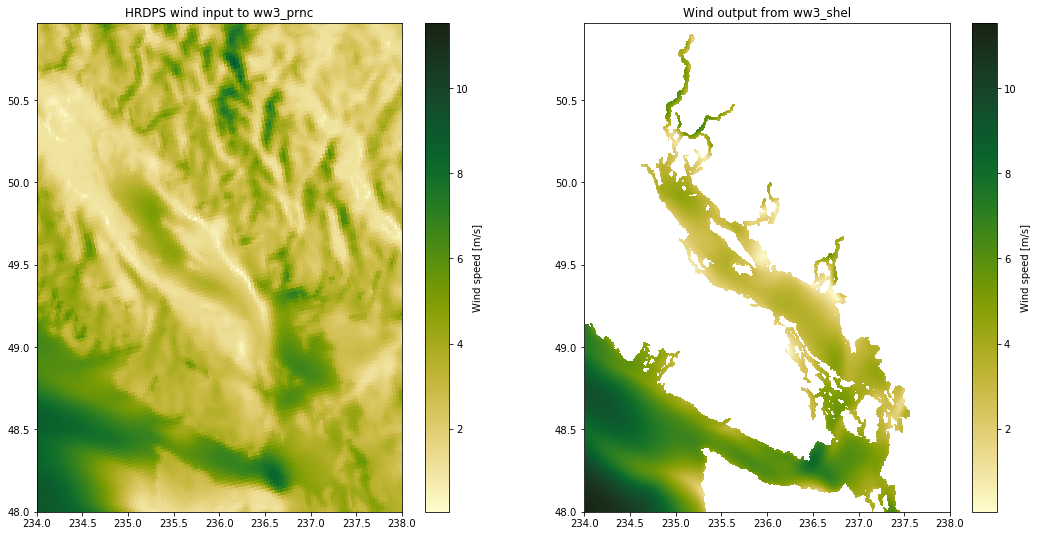

In [72]:
wwf_u_wind = ma.masked_invalid(wwf.uwnd)
wwf_v_wind = ma.masked_invalid(wwf.vwnd)

time = 0
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
mesh = axs[0].pcolormesh(
    hrdps.nav_lon, hrdps.nav_lat, np.sqrt(hrdps.u_wind[time]**2 + hrdps.v_wind[time]**2),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label('Wind speed [m/s]')
axs[0].set_title('HRDPS wind input to ww3_prnc')

axs[1].pcolormesh(
    wwf.longitude, wwf.latitude, np.sqrt(wwf_u_wind[time]**2 + wwf_v_wind[time]**2),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label('Wind speed [m/s]')
axs[1].set_title('Wind output from ww3_shel')

axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())

For a more analytical test,
let's construct a wind field with 2 constant speed patches:

* a patch of 1 m/s westward (`v` component = 0) at the Sentry Shoal buoy
* a patch of 1 m/s northward (`u` component = 0) at the Halibut Bank buoy

In [3]:
hrdps = xr.open_dataset('/results/forcing/atmospheric/GEM2.5/operational/fcst/ops_y2017m01d20.nc')

Near Sentry Shoal:

In [4]:
u_patch_data = np.zeros_like(hrdps.u_wind)
u_patch_data[:, 181:185, 105:109] = 1
u_patch = xr.DataArray(
    data=u_patch_data,
    dims=hrdps.u_wind.dims,
    name=hrdps.u_wind.name,
    attrs=hrdps.u_wind.attrs,
)
print(u_patch)
print(u_patch[12, 180:186, 104:110])

<xarray.DataArray 'u_wind' (time_counter: 24, y: 266, x: 256)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       ..., 
       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Dimensions without coordinates: time_counter, y, x
Attributes:
    short_name: UGRD_10maboveground
    long_name: U-Component of Wind
    level: 10 m above ground
    units: m/s
    coordinates: longitude latitude
<xarray.DataArray 'u_wind' (y: 6, x: 6)>
array([[ 0.,  0.,  0.,  0.,  0.,  0.],
      

Near Halibut Bank:

In [5]:
v_patch_data = np.zeros_like(hrdps.v_wind)
v_patch_data[:, 147:151, 139:143] = 1
v_patch = xr.DataArray(
    data=v_patch_data,
    dims=hrdps.v_wind.dims,
    name=hrdps.v_wind.name,
    attrs=hrdps.v_wind.attrs,
)
print(v_patch)
print(v_patch[12, 146:152, 138:144])

<xarray.DataArray 'v_wind' (time_counter: 24, y: 266, x: 256)>
array([[[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       ..., 
       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ..., 
        [ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.]]])
Dimensions without coordinates: time_counter, y, x
Attributes:
    short_name: VGRD_10maboveground
    long_name: V-Component of Wind
    level: 10 m above ground
    units: m/s
    coordinates: longitude latitude
<xarray.DataArray 'v_wind' (y: 6, x: 6)>
array([[ 0.,  0.,  0.,  0.,  0.,  0.],
      

In [7]:
ds = xr.Dataset(
    data_vars={
        'u_wind': u_patch.rename({'time_counter': 'time'}),
        'v_wind': v_patch.rename({'time_counter': 'time'}),
    },
    coords={
        'time': hrdps.time_counter.rename('time').rename({'time_counter': 'time'}),
        'latitude': hrdps.nav_lat,
        'longitude': hrdps.nav_lon,
    }
)
del ds.u_wind.attrs['coordinates']
del ds.v_wind.attrs['coordinates']
ds

<xarray.Dataset>
Dimensions:    (time: 24, x: 256, y: 266)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-20 2017-01-20T01:00:00 ...
  * y          (y) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
  * x          (x) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 1.5e+04 ...
    latitude   (y, x) float64 45.66 45.67 45.67 45.68 45.68 45.69 45.69 45.7 ...
    longitude  (y, x) float64 233.0 233.0 233.1 233.1 233.1 233.2 233.2 ...
Data variables:
    u_wind     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    v_wind     (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

In [88]:
ds.to_netcdf('SoG_wind_20170120_patches.nc')

(49.2, 50)

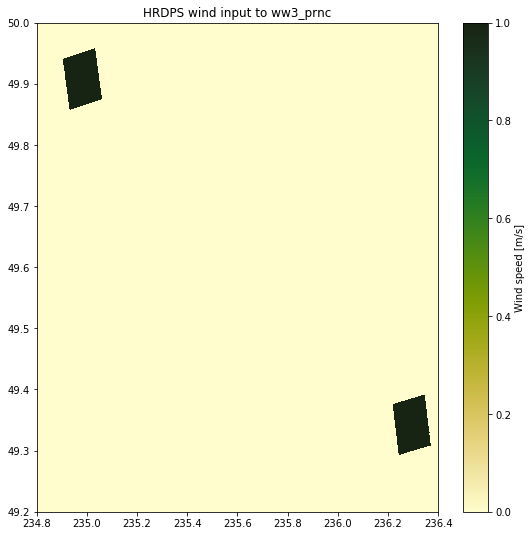

In [8]:
time = 0
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
mesh = ax.pcolormesh(
    ds.longitude, ds.latitude, np.sqrt(ds.u_wind[time]**2 + ds.v_wind[time]**2),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label('Wind speed [m/s]')
ax.set_title('HRDPS wind input to ww3_prnc')

ax.set_xlim(234.8, 236.4)
ax.set_ylim(49.2, 50)

In [3]:
wwf = xr.open_dataset('SoG_ww3_fields_20170120_patches.nc')

In [4]:
ds = xr.open_dataset('SoG_wind_20170120_patches.nc')

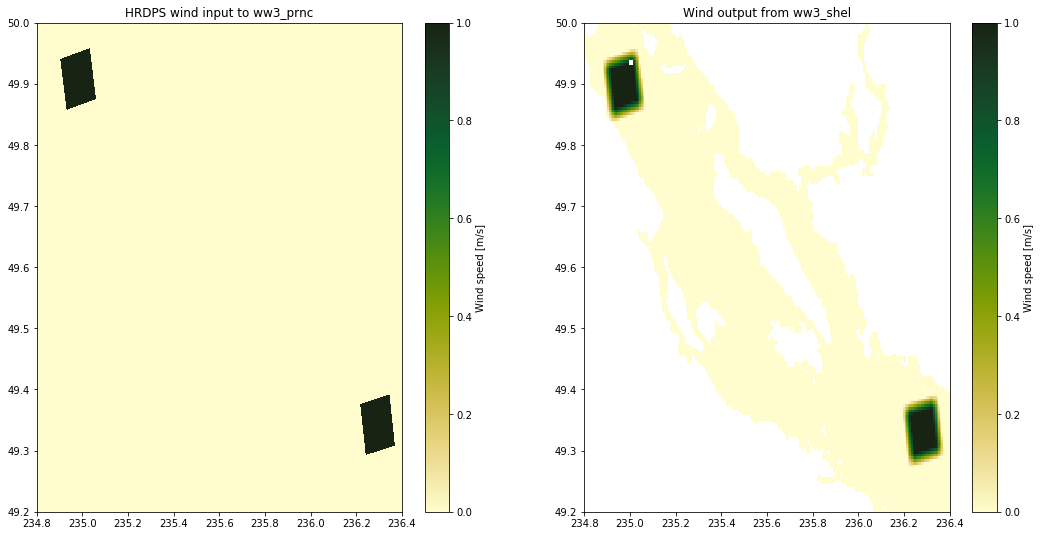

In [5]:
wwf_u_wind = ma.masked_invalid(wwf.uwnd)
wwf_v_wind = ma.masked_invalid(wwf.vwnd)

time = 0
fig, axs = plt.subplots(1, 2, figsize=(18, 9))
mesh = axs[0].pcolormesh(
    ds.longitude, ds.latitude, np.sqrt(ds.u_wind[time]**2 + ds.v_wind[time]**2),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label('Wind speed [m/s]')
axs[0].set_title('HRDPS wind input to ww3_prnc')

axs[1].pcolormesh(
    wwf.longitude, wwf.latitude, np.sqrt(wwf_u_wind[time]**2 + wwf_v_wind[time]**2),
    cmap=cmocean.cm.speed,
)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label('Wind speed [m/s]')
axs[1].set_title('Wind output from ww3_shel')

for ax in axs:
    ax.set_xlim(234.8, 236.4)
    ax.set_ylim(49.2, 50)

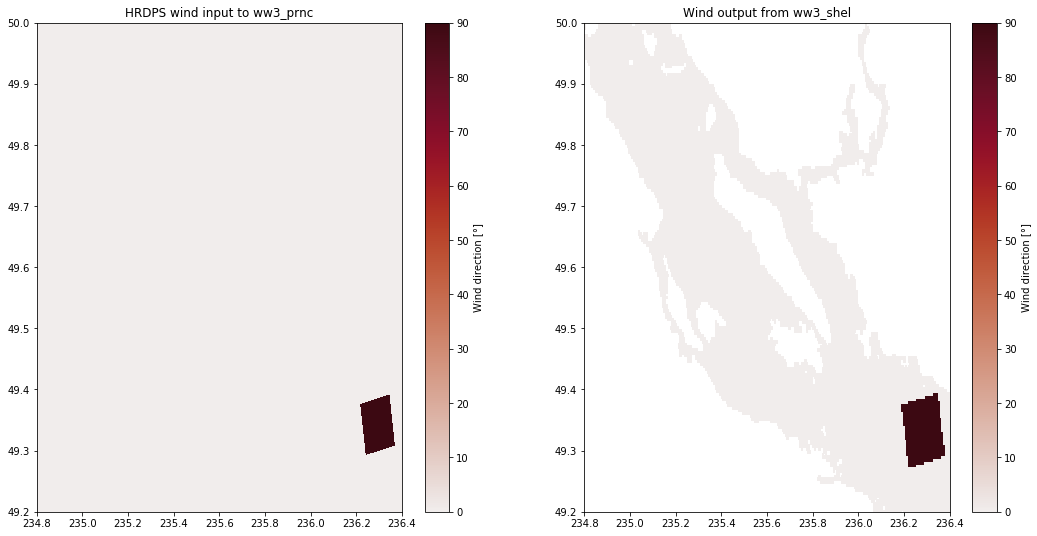

In [37]:
time = 12

fig, axs = plt.subplots(1, 2, figsize=(18, 9))
mesh = axs[0].pcolormesh(
    ds.longitude, ds.latitude, np.rad2deg(np.arctan2(ds.v_wind[time], ds.u_wind[time])),
    cmap=cmocean.cm.amp,
)
cbar = fig.colorbar(mesh, ax=axs[0])
cbar.set_label('Wind direction [°]')
axs[0].set_title('HRDPS wind input to ww3_prnc')

axs[1].pcolormesh(
    wwf.longitude, wwf.latitude, np.rad2deg(np.arctan2(wwf_v_wind[time], wwf_u_wind[time])),
    cmap=cmocean.cm.amp,
)
cbar = fig.colorbar(mesh, ax=axs[1])
cbar.set_label('Wind direction [°]')
axs[1].set_title('Wind output from ww3_shel')

for ax in axs:
    ax.set_xlim(234.8, 236.4)
    ax.set_ylim(49.2, 50)

Evolution of significant wave height:

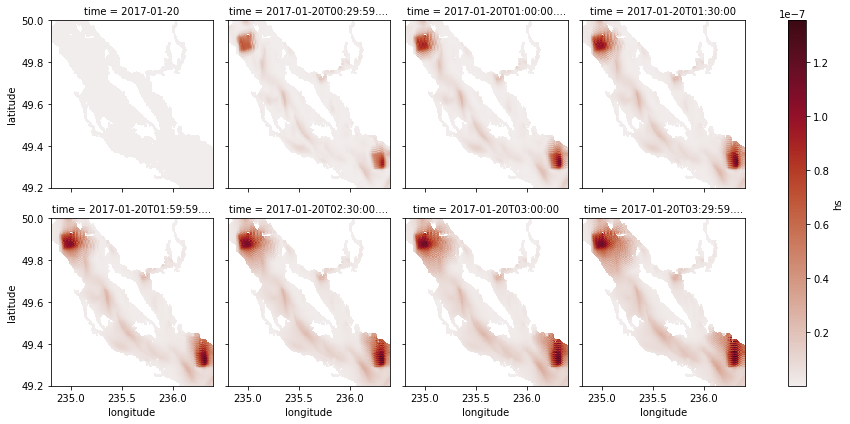

In [15]:
longitude=slice(234.8, 236.4)
latitude=slice(49.2, 50)

(wwf.hs
    .isel(time=slice(0, 8))
    .sel(longitude=longitude, latitude=latitude)
    .plot(col='time', col_wrap=4, cmap=cmocean.cm.amp)
)